# Standard Solar Model

Из книги "АСТРОНОМИЯ Век XXI" 18 points

Date of creation: 17.06.2020

Last updated: 2.07.2020

In [17]:
import math
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

In [23]:
import physics as p
from Sun import SSM18 as s

In [19]:
# h = 1.054E-27 # reduced Planck constant
# c = 3e10 # speed of light
# G = 6.67E-8 # gravitational constant
# kB = 1.381E-16 # Boltzmann constant
# m_prot = 1.67E-24 # масса протона
# m_elec = 9.11E-28 # масса электрона
# alpha = 137 # e2/h/c - постоянная тонкой структуры
# e2 = h*c/alpha
# r_elec = e2/m_elec/c/c # классический радиус электрона
# pi = math.pi # 3.14...
# sigmaT = 8*pi/3*r_elec*r_elec # сечение томсоновского рассеяния на электронах
# kappaT = sigmaT/m_prot
# sigma = pow(pi, 2)*pow(kB, 4)/60*pow(h, -3)*pow(c, -2) # sigma*T^4
# a = pow(pi, 2)*pow(kB, 4)/15*pow(h, -3)*pow(c, -3)
# gamma = 5/3

In [21]:
df = SSM18.load_data()
df

,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Convection
0,0.0000,0.000,15500000.0,1.563000e+02,0.000,0.355,1.1,0.0
1,0.0099,0.046,14800000.0,1.339000e+02,0.079,0.417,1.2,0.0
2,0.0385,0.076,13800000.0,1.081000e+02,0.264,0.497,1.3,0.0
3,0.1038,0.113,12400000.0,7.890000e+01,0.555,0.592,1.4,0.0
4,0.1620,0.138,11400000.0,6.320000e+01,0.718,0.641,1.6,0.0
5,0.2100,0.156,10800000.0,5.360000e+01,0.809,0.668,1.7,0.0
6,0.2580,0.173,10200000.0,4.570000e+01,0.874,0.688,1.8,0.0
7,0.3100,0.190,9600000.0,3.850000e+01,0.921,0.702,1.9,0.0
8,0.3900,0.217,8770000.0,2.940000e+01,0.964,0.716,2.1,0.0
9,0.4700,0.245,8000000.0,2.210000e+01,0.986,0.724,2.4,0.0


In [25]:
s.R

69600000000.0

In [3]:
M_sol = 1.99e33 # solar mass
R_sol = 6.96e10 # solar radius
L_sol = 3.85e33 # solar luminosity
Teff = pow(L_sol/4/pi/sigma/R_sol/R_sol, 1/4) # 5780 solar surface temperature

## Standard Solar Model

In [27]:
r1 = df['Radius']
m1 = df['Mass']
t1 = df['Temperature']
d1 = df['Density']
l1 = df['Luminosity']
X1 = df['Hydrogen']
# p1 = df['Pressure']

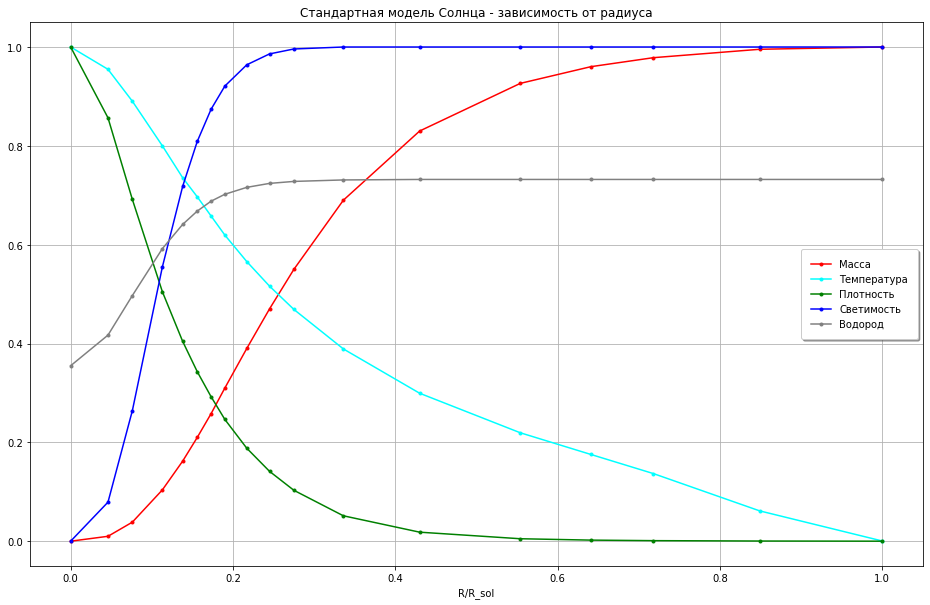

In [28]:
plt.figure(figsize=(16, 10))
ax = plt.axes()
plt.plot(r1, m1, color='red', marker='.', label='Масса')
plt.plot(r1, t1/t1[0], color='cyan', marker='.', label='Температура')
plt.plot(r1, d1/d1[0], color='green', marker='.', label='Плотность')
plt.plot(r1, l1, color='blue', marker='.', label='Светимость')
plt.plot(r1, X1, color='gray', marker='.', label='Водород')
# plt.plot(r1, p1/p1[0], color='black', marker='.', label='Давление')
# plt.xlim(-0.9,+0.9)
# plt.ylim(0, 50)
plt.xlabel('R/R_sol')
plt.ylabel('')
plt.title('Стандартная модель Солнца - зависимость от радиуса')
ax.grid(b=True, which='both')

ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

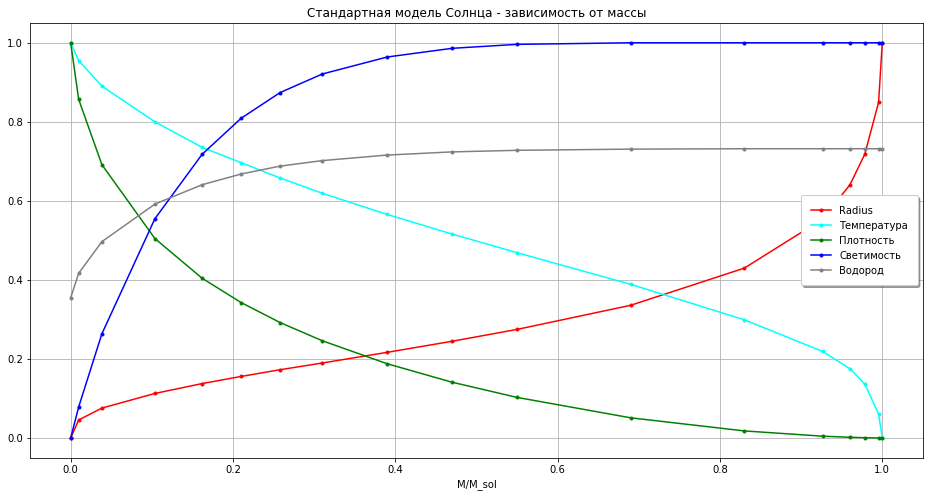

In [30]:
plt.figure(figsize=(16, 8))
ax = plt.axes()
plt.plot(m1, r1, color='red', marker='.', label='Radius')
plt.plot(m1, t1/15.5e6, color='cyan', marker='.', label='Температура')
plt.plot(m1, d1/156.3, color='green', marker='.', label='Плотность')
plt.plot(m1, l1, color='blue', marker='.', label='Светимость')
plt.plot(m1, X1, color='gray', marker='.', label='Водород')
# plt.plot(m1, p1/p1[0], color='black', marker='.', marker='.', label='Давление')
#plt.plot(r1, M1, color='', label='')
# plt.xlim(-0.9,+0.9)
# plt.ylim(0, 50)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Стандартная модель Солнца - зависимость от массы')
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

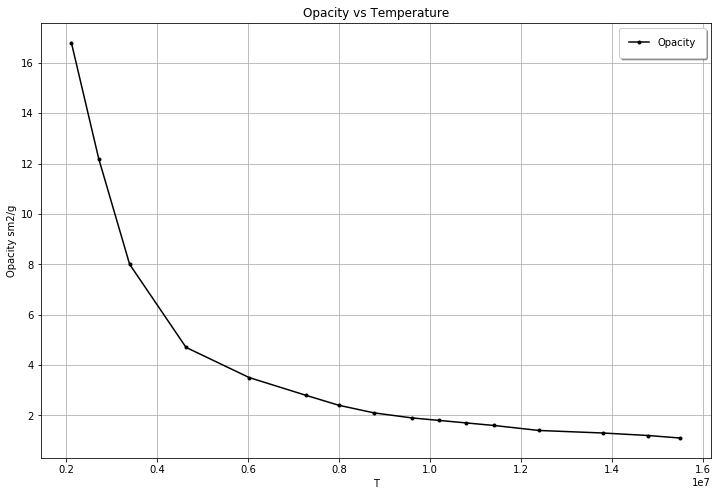

In [9]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
plt.plot(t1[:16], k1[:16], color='black', marker='.', label='Opacity')
# plt.plot(r1, myk, color='red', marker='.', label='Непроз my')
#plt.xlim(6, 7.25)
#plt.ylim(0, 20)
plt.xlabel('T')
plt.ylabel('Opacity sm2/g')
plt.title('Opacity vs Temperature')
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

## Проверка выполнения уравнений в стандартной модели

In [10]:
dim = 17
r = np.zeros(dim)
p = np.zeros(dim)
m = np.zeros(dim)
d = np.zeros(dim)
t = np.zeros(dim)
l = np.zeros(dim)
k = np.zeros(dim)
x = np.zeros(dim)
for i in range(dim) :
    r[i] = (r1[i] + r1[i+1])/2*R_sol
    p[i] = (p1[i] + p1[i+1])/2
    m[i] = (m1[i] + m1[i+1])/2*M_sol
    d[i] = (d1[i] + d1[i+1])/2
    t[i] = (t1[i] + t1[i+1])/2
    l[i] = (l1[i] + l1[i+1])/2*L_sol
    k[i] = (k1[i] + k1[i+1])/2
    x[i] = (X1[i] + X1[i+1])/2
dr = np.zeros(dim)
dp = np.zeros(dim)
dm = np.zeros(dim)
dd = np.zeros(dim)
dt = np.zeros(dim)
dl = np.zeros(dim)   
for i in range(dim) :
    dp[i] = (p1[i+1] - p1[i])/(r1[i+1] - r1[i])/R_sol
    dm[i] = (m1[i+1] - m1[i])/(r1[i+1] - r1[i])/R_sol*M_sol
    dd[i] = (d1[i+1] - d1[i])/(r1[i+1] - r1[i])/R_sol
    dt[i] = (t1[i+1] - t1[i])/(r1[i+1] - r1[i])/R_sol
    dl[i] = (l1[i+1] - l1[i])/(r1[i+1] - r1[i])/R_sol*L_sol

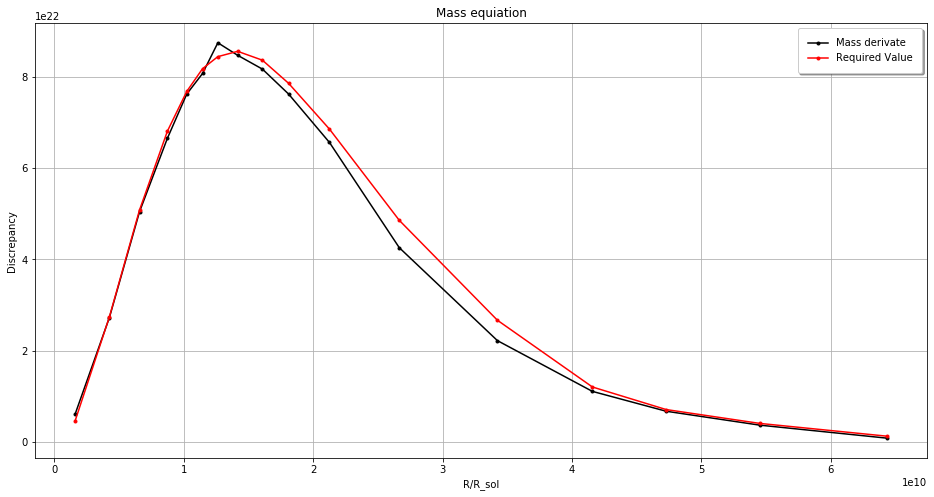

In [11]:
# Mass
w = np.zeros(dim)
w = 4*pi*r*r*d
err = ((dm - w)/w)**2

plt.figure(figsize=(16, 8))
ax = plt.axes()
#plt.plot(r, err, color='black', marker='.', label='Квадрат ошибки')
plt.plot(r, dm, color='black', marker='.', label='Mass derivate')
plt.plot(r, w, color='red', marker='.', label='Required Value')
# plt.plot(r1, myk, color='red', marker='.', label='Непроз my')
# plt.xlim(6, 7.25)
# plt.ylim(0, 20)
plt.xlabel('R/R_sol')
plt.ylabel('Discrepancy')
plt.title('Mass equiation')
ax.grid(b=True, which='both')

ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);    

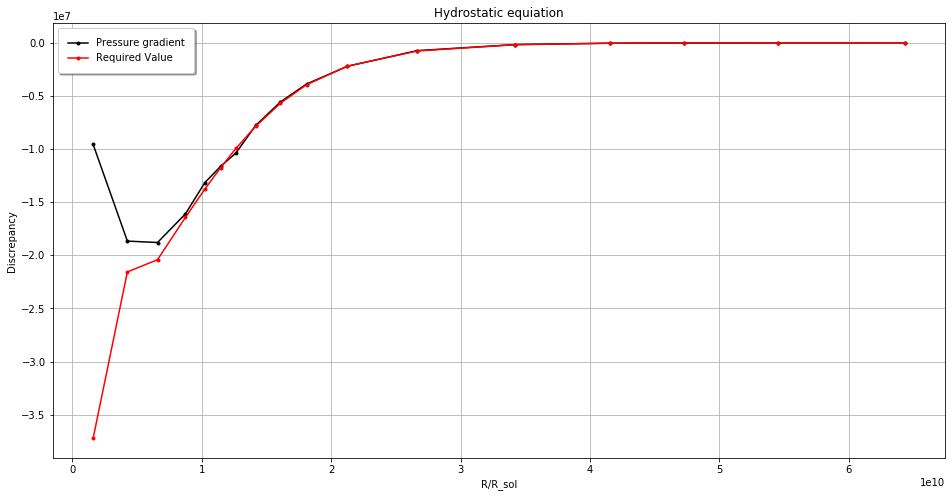

In [12]:
# Hydrostatic equilibrium
w = -G*m*d/r/r
err = ((dp - w)/w)**2
plt.figure(figsize=(16, 8))
ax = plt.axes()
plt.plot(r, dp, color='black', marker='.', label='Pressure gradient')
plt.plot(r, w, color='red', marker='.', label='Required Value')
# plt.plot(r, err, color='black', marker='.', label='Квадрат ошибки')
# plt.plot(r1, myk, color='red', marker='.', label='Непроз my')
# plt.xlim(6, 7.25)
# plt.ylim(0, 20)
plt.xlabel('R/R_sol')
plt.ylabel('Discrepancy')
plt.title('Hydrostatic equiation')
ax.grid(b=True, which='both')

ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);    

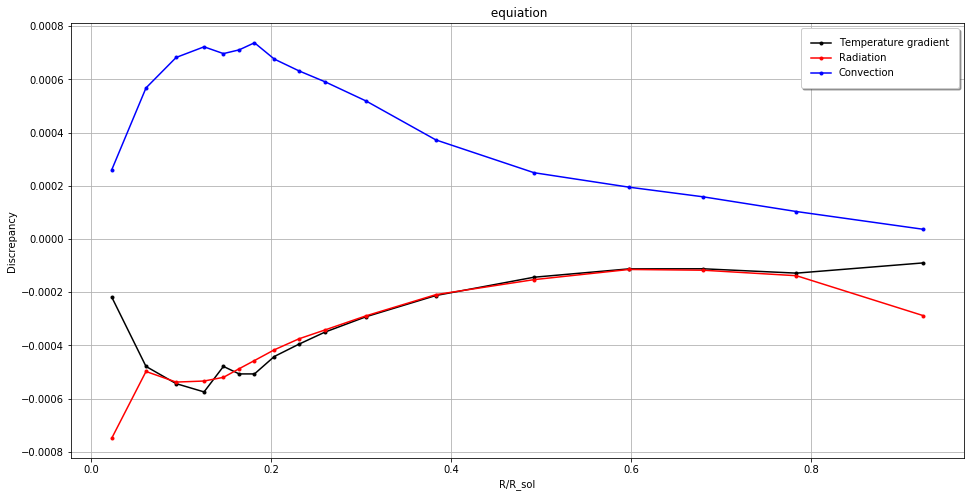

In [13]:
# Radiation
w = -3*k*d*l/64/pi/r/r/sigma/pow(t, 3)
err = ((dt - w)/w)**2
# Convection
wc = -0.4*t/p*dp

plt.figure(figsize=(16, 8))
ax = plt.axes()
# plt.plot(r/R_sol, err, color='black', marker='.', label='Квадрат ошибки')
plt.plot(r/R_sol, dt, color='black', marker='.', label='Temperature gradient')
plt.plot(r/R_sol, w, color='red', marker='.', label='Radiation')
plt.plot(r/R_sol, wc, color='blue', marker='.', label='Convection')
# plt.plot(r1, myk, color='red', marker='.', label='Непроз my')
# plt.xlim(6, 7.25)
# plt.ylim(0, 20)
plt.xlabel('R/R_sol')
plt.ylabel('Discrepancy')
plt.title(' equiation')
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);    

In [14]:
# Зельдович, стр 70, 71:
# Скорость энерговыделения в p-p реакции [эрг/с/г] деленная на X
def E0pp(den, T, X) :
    T0 = (1e6, 5e6, 10e6, 15e6, 20e6, 30e6)
    e0 = (4e-9, 1.8e-3, 6.8e-2, 0.377, 1.09, 4.01)
    n = (10.6, 5.95, 4.60, 3.95, 3.64, 3.03)
    found = False
    for i in range (len(T0) - 1) :
        if T < pow(T0[i]*T0[i+1], 0.5) :
            found = True
            break;
        if not found :
            i = len(T0) - 1
    # print('i=%d T0=%.1e e0=%.3e n=%.2f' % (i, T0[i], e0[i], n[i]))
    return den*X*e0[i]*pow(T/T0[i], n[i])

# Скорость энерговыделения в CNO цикле [эрг/с/г] деленная на X
def E0cno(den, T, XCNO) :
    T0 = (6e6, 10e6, 15e6, 20e6, 30e6, 50e6, 100e6)
    e0 = (9e-10, 3.4e-4, 1.94, 4.5e2, 4.1e5, 6.2e8, 1.9e12)
    n = (27.3, 22.9, 19.9, 18.0, 15.6, 13.6, 10.2)
    found = False
    for i in range (len(T0) - 1) :
        if T < pow(T0[i]*T0[i+1], 0.5) :
            found = True
            break;
    if not found :
        i = len(T0) - 1 
    # print('i=%d T0=%.1e e0=%.3e n=%.2f' % (i, T0[i], e0[i], n[i]))
    return den*XCNO*e0[i]*pow(T/T0[i], n[i])

# Полное энерговыделение - домножаем на X.
def Etot(den, T, X, Y, Z) :
    return X*(E0pp(den, T, X) + E0cno(den, T, Z))
# For best fit to SSM18:
#     return 1.3*E0pp(den, T, X) + 3.5*E0cno(den, T, Z)

In [15]:
# Energy generation
e = dl/4/pi/r/r/d

In [16]:
e_calc = np.zeros(dim)
e_calc0 = np.zeros(dim)
for i in range(dim) :
    X = x[i]
    Z = 0.02
    Y = 1 - X -Z
    e_calc[i] = Etot(d[i], t[i], X, Y, Z)
    X = x[dim - 1]
    Y = 1 - X -Z
    e_calc0[i] = Etot(d[i], t[i], X, Y, Z)

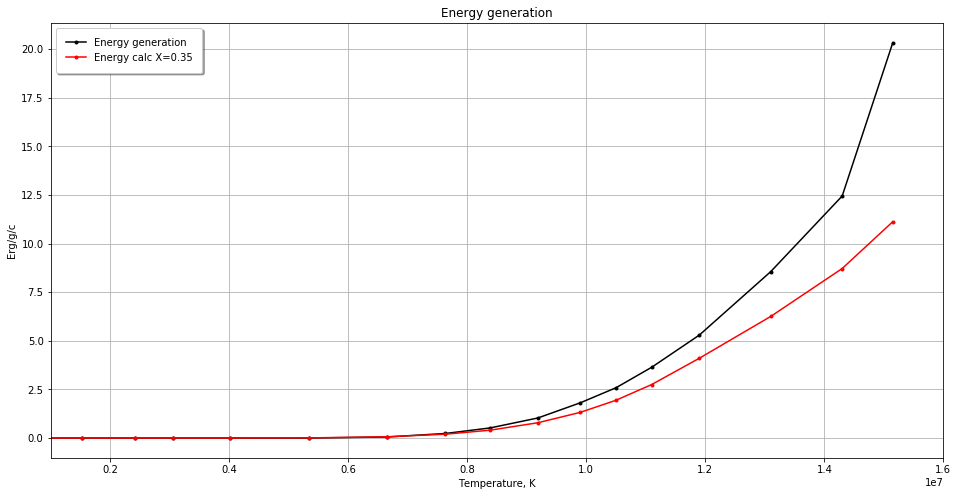

In [17]:
plt.figure(figsize=(16, 8))
ax = plt.axes()
# plt.plot(r/R_sol, err, color='black', marker='.', label='Квадрат ошибки')
plt.plot(t, e, color='black', marker='.', label='Energy generation')
plt.plot(t, e_calc, color='red', marker='.', label='Energy calc X=0.35')
# plt.plot(t, e_calc0, color='green', marker='.', label='Energy calc X=0.71')
#plt.plot(r/R_sol, w, color='red', marker='.', label='Required Value')
# plt.plot(r1, myk, color='red', marker='.', label='Непроз my')
plt.xlim(1e6, 16e6)
# plt.ylim(0, 20)
plt.xlabel('Temperature, K')
plt.ylabel('Erg/g/c')
plt.title('Energy generation')
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);    

## Функции для модели

In [18]:
def save_model(df, filename):
    _ = df.to_csv(line_terminator='\n')
#     filename = "SSM18.csv" % epoch
    print(filename)
    csv_file = open(filename, "wt")
    n = csv_file.write(_)
    csv_file.close()

In [1]:
from Sun.SSM18 import SSM18


ImportError: cannot import name 'SSM18' from 'Sun.SSM18' (C:\Users\boris_2\notebooks\StarModels\Sun\SSM18.py)